In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample

import statsmodels.formula.api as smf

from scipy import stats

%matplotlib inline
plt.style.use('seaborn-white')

# Data

In [2]:
df_auto = pd.read_csv('Data/Auto.csv', na_values='?').dropna()
df_auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


In [3]:
df_auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


# 5.1 Cross-Validation

## 5.1.1 The Validation Set Approach

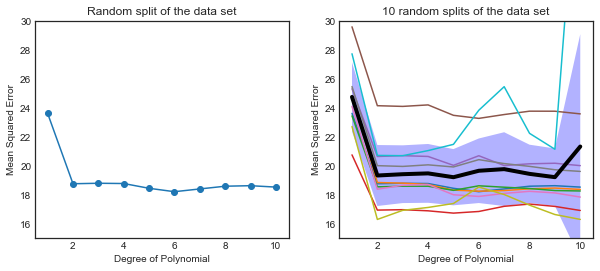

In [4]:
test_prop = 0.5
p_order = np.arange(1,11)
r_state = np.arange(0,10)

# r_state: 10 splits of the data 
# p_order: polynomials of order up to 10
X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

regr = skl_lm.LinearRegression()

# Generate 10 random splits of the dataset
for (i, j), v in np.ndenumerate(Z):
    poly = PolynomialFeatures(int(X[i,j]))
    X_poly = poly.fit_transform(df_auto.horsepower.values.reshape(-1,1))
    
    X_train, X_test, y_train, y_test = train_test_split(X_poly, df_auto.mpg.ravel(),
                                                        test_size=test_prop, random_state=Y[i,j])
                                                                        
    regr.fit(X_train, y_train)
    pred = regr.predict(X_test)
    Z[i, j] = mean_squared_error(y_test, pred)

# plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# Left plot (first split)
ax1.plot(X.T[0], Z.T[0], '-o')
ax1.set_title('Random split of the data set')

# Right plot (all splits)
ax2.plot(X, Z)
ax2.set_title('10 random splits of the data set')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5, 10.5)
    ax.set_xticks(range(2, 11, 2));
    
# mean and std
val_meanMSE = np.mean(Z, axis=1)
val_stdMSE = np.std(Z, axis=1)
ax2.plot(X.T[0], val_meanMSE, 'k', linewidth=4)
ax2.fill_between(X.T[0], val_meanMSE+val_stdMSE, val_meanMSE-val_stdMSE, facecolor='blue', alpha=0.3);

val_MSE = Z.T[0]

## 5.1.2 Leave-One-Out Cross-Validation

In [5]:
regr = skl_lm.LinearRegression()
loocv_scores = list()
loo = LeaveOneOut()

for p in p_order:
    poly = PolynomialFeatures(p)
    X_poly = poly.fit_transform(df_auto.horsepower.values.reshape(-1,1))
    score = cross_val_score(regr, X_poly, df_auto.mpg, cv=loo, scoring='neg_mean_squared_error')
    loocv_scores.append((-score.mean(), score.std()))
loocv_scores = np.array(loocv_scores)

## 5.1.3 k-Fold Cross-Validation

In [6]:
regr = skl_lm.LinearRegression()
kfoldcv_scores = list()

for p in p_order:
    poly = PolynomialFeatures(p)
    X_poly = poly.fit_transform(df_auto.horsepower.values.reshape(-1,1))
    # with shuffle=True we get much better mean and std
    # but then each train/test split is different across models
    kfold = KFold(n_splits=10, shuffle=False)
    score = cross_val_score(regr, X_poly, df_auto.mpg, cv=kfold, scoring='neg_mean_squared_error')
    kfoldcv_scores.append((-score.mean(), score.std()))
kfoldcv_scores = np.array(kfoldcv_scores)

### FIGURE 5.4

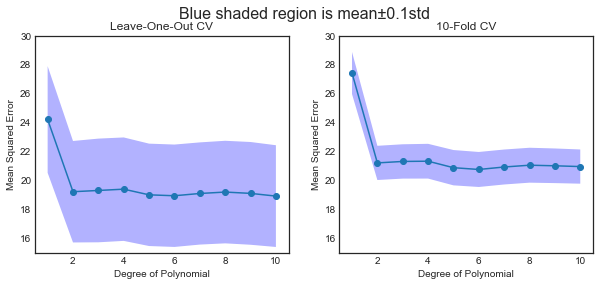

In [7]:
# plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Blue shaded region is mean\u00B10.1std', fontsize=16)

# left plot is LOOCV
ax1.plot(p_order, loocv_scores[:,0], '-o')
ax1.set_title('Leave-One-Out CV')
ax1.fill_between(p_order, loocv_scores[:,0]+0.1*loocv_scores[:,1], loocv_scores[:,0]-0.1*loocv_scores[:,1],
                 facecolor='blue', alpha=0.3);

# right plot: K-fold CV
ax2.plot(p_order, kfoldcv_scores[:,0], '-o')
ax2.set_title('10-Fold CV')
ax2.fill_between(p_order, kfoldcv_scores[:,0]+0.1*kfoldcv_scores[:,1], kfoldcv_scores[:,0]-0.1*kfoldcv_scores[:,1],
                 facecolor='blue', alpha=0.3);

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5, 10.5)
    ax.set_xticks(range(2, 11, 2));

## 5.1.4 Bias-Variance Trade-Off for k-Fold Cross-Validation

In [8]:
print(f'Mean \u00B1 std of MSE for p=2:')
print(f'    Validation set:   {val_MSE[1]:.2f}\u00B1{val_stdMSE[1]:.2f}')
print(f'    Leave-One-Out CV: {loocv_scores[1,0]:.2f}\u00B1{loocv_scores[1,1]:.2f}')
print(f'    10-Fold CV:       {kfoldcv_scores[1,0]:.2f}\u00B1{kfoldcv_scores[1,1]:.2f}')

Mean ± std of MSE for p=2:
    Validation set:   18.76±2.10
    Leave-One-Out CV: 19.25±35.00
    10-Fold CV:       21.24±11.80


## 5.1.5 Cross-Validation on Classification Problems

In [9]:
# TODO

# 5.2 The Bootstrap

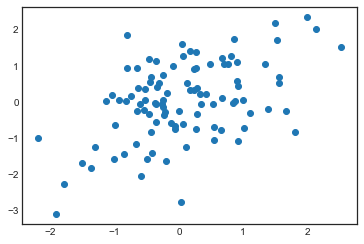

In [10]:
mean = np.array([0, 0])
sigmaX = np.sqrt(1)
sigmaY = np.sqrt(1.25)
sigmaXY = 0.5
cov = np.array([[sigmaX, sigmaXY], [sigmaXY, sigmaY]])
N = 100
sample = np.random.multivariate_normal(mean, cov, (N,)) 
plt.scatter(sample[:,0], sample[:,1]);

In [11]:
def est_alpha(est_sigmaX, est_sigmaY, est_sigmaXY):
    return (est_sigmaY**2 - est_sigmaXY)/(est_sigmaX**2 + est_sigmaY**2 - 2*est_sigmaXY)
true_alpha = est_alpha(sigmaX, sigmaY, sigmaXY)
print(f'True alpha: {true_alpha:.1f}')

True alpha: 0.6


In [12]:
# generate N_simulations from the original distribution
N_samples = 100
N_simulations = 1000
alpha_sim = np.zeros((N_simulations,))
for i_sim in range(N_simulations):
    sample = np.random.multivariate_normal(mean, cov, (N_samples,)) 
    est_mean = np.mean(sample)
    est_cov = np.cov(sample, rowvar=False)
    alpha_sim[i_sim] = est_alpha(est_cov[0,0], est_cov[1,1], est_cov[0,1])
sim_alpha = np.mean(alpha_sim)
sim_alpha_std = np.std(alpha_sim)

In [13]:
# bootstrap samples
N_samples = 100
N_bootstrap = 1000
alpha_bst = np.zeros((N_bootstrap,))
sample = np.random.multivariate_normal(mean, cov, (N_samples,)) 
for i_sim in range(N_bootstrap):
    sample_bootstrap = resample(sample, replace=True)
    est_mean = np.mean(sample_bootstrap)
    est_cov = np.cov(sample_bootstrap, rowvar=False)
    alpha_bst[i_sim] = est_alpha(est_cov[0,0], est_cov[1,1], est_cov[0,1])
bst_alpha = np.mean(alpha_bst)
bst_alpha_std = np.std(alpha_bst)

C:\Users\villanueva\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\villanueva\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Population estimate α: 0.590±0.150
Bootstrap estimate α: 0.647±0.141


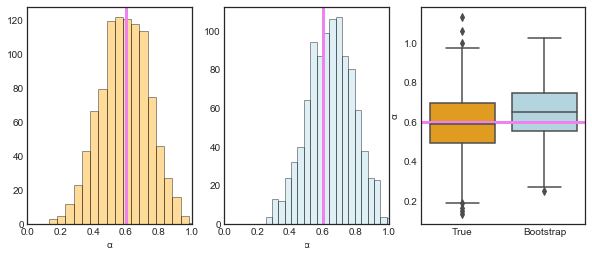

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))

N_bins = int((max(alpha_sim)-min(alpha_sim))/0.05)

# population histigram
sns.distplot(alpha_sim, kde=False, hist_kws=dict(edgecolor="k", linewidth=1), bins=N_bins, color='orange', ax=ax1);
ax1.axvline(true_alpha, linewidth=3, color='violet')

# bootstrap histogram
sns.distplot(alpha_bst, kde=False, hist_kws=dict(edgecolor="k", linewidth=1), bins=N_bins, color='lightblue', ax=ax2);
ax2.axvline(true_alpha, linewidth=3, color='violet')

# boxplots
df = pd.DataFrame({'True': alpha_sim, 'Bootstrap': alpha_bst})
sns.boxplot(data=df, orient='v', palette={'True': 'orange', 'Bootstrap': 'lightblue'}, ax=ax3)
ax3.axhline(true_alpha, linewidth=3, color='violet')
ax3.set_ylabel('\u03B1')

for ax in (ax1, ax2):
    ax.set_xlabel('\u03B1')
    ax.set_xlim(0.0, 1.0)
    
# the books gives the standard error, which is the std dev of the sampling distribution
print(f'Population estimate \u03B1: {sim_alpha:.3f}\u00B1{sim_alpha_std:.3f}')
print(f'Bootstrap estimate \u03B1: {bst_alpha:.3f}\u00B1{bst_alpha_std:.3f}')

# 5.3 Lab: Cross-Validation and the Bootstrap

## 5.3.1 The Validation Set Approach

## 5.3.2 Leave-One-Out Cross-Validation

## 5.3.3 k-Fold Cross-Validation

These three sections have been already done in sections 5.1.1-5.1.3

## 5.3.4 The Bootstrap

### Estimating the Accuracy of a Statistic of Interest

Already done in 5.2

### Estimating the Accuracy of a Linear Regression Model

In [60]:
# bootstrap function
def bootstrap(data, function, N_bootstrap):
    '''Compute N_boostrap samples from data and apply function to them. 
    Returns the mean and std of the function result'''
    fn_real = np.array(function(data))
    bst_fn = list()
    for i in range(N_bootstrap):
        if type(data) == tuple:
            sample_bootstrap = resample(*data, replace=True)
        else:
            sample_bootstrap = resample(data, replace=True)
        bst_fn.append(function(sample_bootstrap))
    bst_fn = np.array(bst_fn)
    bst_fn_mean = np.mean(bst_fn, axis=0)
    bst_fn_std = np.std(bst_fn, axis=0)
    return bst_fn_mean, bst_fn_std, fn_real

In [61]:
# example
bootstrap(np.array([1,2,3]), lambda x: (x.mean(), x.mean()**2), 1000)

(array([1.98866667, 4.17444444]),
 array([0.46866761, 1.89831992]),
 array([2., 4.]))

In [62]:
def linear_model(data):
    X = data[0]
    y = data[1]
    regr = skl_lm.LinearRegression()
    #X = df_auto.horsepower.values.reshape(-1,1)
    #y = df_auto.mpg                                              
    regr.fit(X, y)
    return (regr.intercept_, *regr.coef_)

In [95]:
data = (df_auto.horsepower.values.reshape(-1,1), df_auto.mpg)
bst_res = bootstrap(data, linear_model, 1000)
df_bst = pd.DataFrame(np.array(bst_res).T, index=['Intercept', 'Horsepower'], columns=['Mean', 'Std dev', 'Real'])
df_bst['Bias'] = df_bst['Mean'] - df_bst['Real']
df_bst[['Real', 'Bias', 'Std dev']]

,Real,Bias,Std dev
Intercept,39.935861,0.055151,0.842099
Horsepower,-0.157845,-0.000617,0.007338


In [96]:
est = smf.ols('mpg ~ horsepower', df_auto).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,39.9359,0.717,55.660,0.000,38.525,41.347
horsepower,-0.1578,0.006,-24.489,0.000,-0.171,-0.145


In [109]:
def quadratic_model(data):
    X = data[0]
    poly = PolynomialFeatures(2)
    X_poly = poly.fit_transform(X)
    y = data[1]
    regr = skl_lm.LinearRegression()                                        
    regr.fit(X_poly, y)
    return (regr.intercept_, *regr.coef_[1:])

In [111]:
data = (df_auto.horsepower.values.reshape(-1,1), df_auto.mpg)
bst_res = bootstrap(data, quadratic_model, 1000)
df_bst = pd.DataFrame(np.array(bst_res).T, index=['Intercept', 'Horsepower', 'Horsepower**2'], columns=['Mean', 'Std dev', 'Real'])
df_bst['Bias'] = df_bst['Mean'] - df_bst['Real']
df_bst[['Real', 'Bias', 'Std dev']]

,Real,Bias,Std dev
Intercept,56.900100,-0.056158,2.035524
Horsepower,-0.466190,0.000825,0.032500
Horsepower**2,0.001231,-0.000002,0.000117


In [118]:
est = smf.ols('mpg ~ horsepower + np.power(horsepower,2)', df_auto).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.9001,1.800,31.604,0.000,53.360,60.440
horsepower,-0.4662,0.031,-14.978,0.000,-0.527,-0.405
"np.power(horsepower, 2)",0.0012,0.000,10.080,0.000,0.001,0.001
